In [ ]:
# === IMPORTS ===
import pandas as pd
import numpy as np
import re

In [ ]:
# === LOAD DATASETS ===
daily_dialog = pd.read_csv("daily_dialog.csv")
empathetic_dialogues = pd.read_csv("empathetic_dialogues.csv")
goemotions = pd.read_csv("goemotions_cleaned.csv")

In [ ]:
# === DAILYDIALOG PREPROCESSING ===

# Emotion ID to label mapping
daily_dialog_emotion_map = {
    0: "neutral", 1: "happiness", 2: "anger", 3: "disgust",
    4: "sadness", 5: "surprise", 6: "fear"
}

# Convert stringified lists to actual lists of integers
def fix_list_format(s):
    if isinstance(s, str):
        s = re.sub(r"\[|\]", "", s)
        return list(map(int, s.strip().split()))
    return []

daily_dialog["act"] = daily_dialog["act"].apply(fix_list_format)
daily_dialog["emotion"] = daily_dialog["emotion"].apply(fix_list_format)

# Split dialog text into individual utterances
def split_dialog_utterances(dialog_str):
    if isinstance(dialog_str, str):
        dialog_str = dialog_str.strip()[1:-1]  # remove outer brackets
        utterances = dialog_str.split("  ")    # split by double space
        return [utt.strip(" '\"") for utt in utterances if utt.strip()]
    return []

daily_dialog["dialog"] = daily_dialog["dialog"].apply(split_dialog_utterances)

# Flatten dialog rows into turn-level format
daily_dialog_flat = []
for idx, row in daily_dialog.iterrows():
    for i, utterance in enumerate(row["dialog"]):
        daily_dialog_flat.append({
            "dialog_id": idx,
            "turn": i,
            "utterance": utterance,
            "act": row["act"][i] if i < len(row["act"]) else None,
            "emotion": daily_dialog_emotion_map.get(row["emotion"][i], "unknown")
        })
daily_dialog_df = pd.DataFrame(daily_dialog_flat)


In [ ]:
# === EMPATHETIC DIALOGUES PREPROCESSING ===

# Drop irrelevant columns if present
drop_cols = ["Unnamed: 0", "Unnamed: 5", "Unnamed: 6"]
empathetic_dialogues.drop(columns=[col for col in drop_cols if col in empathetic_dialogues.columns], inplace=True)

# Split multi-line dialog into clean utterance list
def split_dialog(dialog_text):
    lines = dialog_text.strip().split("\n")
    return [
        line.replace("Customer :", "").replace("Agent :", "").strip()
        for line in lines if line.strip()
    ]

# Flatten into turn-level format
empathetic_dialog_flat = []
for idx, row in empathetic_dialogues.iterrows():
    turns = split_dialog(row["empathetic_dialogues"])
    for i, utterance in enumerate(turns):
        empathetic_dialog_flat.append({
            "dialog_id": idx,
            "turn": i,
            "utterance": utterance,
            "emotion": row["emotion"],
            "situation": row["Situation"]
        })
empathetic_dialog_df = pd.DataFrame(empathetic_dialog_flat)

In [ ]:
# === GOEMOTIONS PREPROCESSING ===

# Clean stray symbols from emotion labels
goemotions["emotion"] = goemotions["emotion"].str.replace(r"[{}]", "", regex=True).str.strip()

# Rename and standardize format
goemotions_df = goemotions.rename(columns={"text": "utterance"})
goemotions_df["dialog_id"] = -1  # No dialog context
goemotions_df["turn"] = 0        # Single turn entries

In [ ]:
# === SAMPLE OUTPUTS ===
print("DailyDialog Sample:")
print(daily_dialog_df.head(3))
print("\nEmpathetic Dialogues Sample:")
print(empathetic_dialog_df.head(3))
print("\nGoEmotions Sample:")
print(goemotions_df.head(3))

DailyDialog Sample:
   dialog_id  turn                                          utterance  act  \
0          0     0  Say , Jim , how about going for a few beers af...    3   
1          1     0  Can you do push-ups ? '\n " Of course I can . ...    2   
2          2     0  Can you study with the radio on ? '\n ' No , I...    2   

   emotion  
0  neutral  
1  neutral  
2  neutral  

Empathetic Dialogues Sample:
   dialog_id  turn                                          utterance  \
0          0     0  I remember going to see the fireworks with my ...   
1          0     1                                                      
2          1     0                This was a best friend. I miss her.   

       emotion                                          situation  
0  sentimental  I remember going to the fireworks with my best...  
1  sentimental  I remember going to the fireworks with my best...  
2  sentimental  I remember going to the fireworks with my best...  

GoEmotions Sample:


In [ ]:
# === STANDARDIZE COLUMNS FOR MERGING ===

# DailyDialog: already has 'utterance', 'emotion', 'dialog_id', 'turn'
daily_dialog_std = daily_dialog_df.copy()
daily_dialog_std["source"] = "DailyDialog"
daily_dialog_std["situation"] = None  # Not available

# EmpatheticDialogues: already has required columns
empathetic_dialog_std = empathetic_dialog_df[["dialog_id", "turn", "utterance", "emotion", "situation"]].copy()
empathetic_dialog_std["source"] = "EmpatheticDialogues"

# GoEmotions: fill in missing columns
goemotions_std = goemotions_df[["dialog_id", "turn", "utterance", "emotion"]].copy()
goemotions_std["situation"] = None
goemotions_std["source"] = "GoEmotions"

# === COMBINE ALL DATASETS ===
combined_df = pd.concat([daily_dialog_std, empathetic_dialog_std, goemotions_std], ignore_index=True)
combined_df["emotion"] = combined_df["emotion"].str.strip().str.lower()
combined_df["uid"] = combined_df.index
# Drop rows where utterance is missing or just whitespace
combined_df = combined_df[combined_df["utterance"].str.strip().astype(bool)]

# Reset index after dropping
combined_df.reset_index(drop=True, inplace=True)

# Preview the combined dataset
combined_df.sample(5)


,dialog_id,turn,utterance,act,emotion,source,situation,uid
108751,-1,0,what level of bloom would you think is appropr...,NaN,curiosity,GoEmotions,None,173342
69620,58502,0,That's a long time! You and your partner must ...,NaN,faithful,EmpatheticDialogues,Every day I am faithful to my husband,128080
54830,43712,0,I felt bad for my friend. They were going thro...,NaN,caring,EmpatheticDialogues,I felt bad for my friend. They were going thro...,98504
133734,-1,0,"Not sure about OP, but caffeine tends to make ...",NaN,neutral,GoEmotions,None,198325
9281,9281,0,"Excuse me , can you help me figure out how to ...",3.0,neutral,DailyDialog,None,9281


In [ ]:
# Total number of rows in the combined dataframe
total_rows = combined_df.shape[0]

# Count of duplicate rows based on all columns
duplicate_rows = combined_df.duplicated().sum()

print(f"Total rows: {total_rows}")
print(f"Duplicate rows: {duplicate_rows}")


Total rows: 145754
Duplicate rows: 0


In [ ]:
# Drop invalid labels and low-count labels (< 5)
invalid_labels = ['rater_id', 'example_very_unclear', 'nan']

# Count frequencies
label_counts = combined_df['emotion'].value_counts()

# Filter labels with >= 5 samples and not in the invalid list
valid_labels = label_counts[label_counts >= 10].index
valid_labels = [label for label in valid_labels if label not in invalid_labels]

# Apply the filter
combined_df = combined_df[combined_df['emotion'].isin(valid_labels)].reset_index(drop=True)



In [ ]:
# Lowercase and strip whitespaces
combined_df['emotion'] = combined_df['emotion'].str.lower().str.strip()

standardize_emotions = {
    'angry': 'anger',
    'annoyed': 'annoyance',
    'disappointed': 'disappointment',
    'sad': 'sadness',
    'joyful': 'joy',
    'excited': 'excitement',
    'terrified': 'fear',
    'afraid': 'fear',
    'grateful': 'gratitude',
    'nostalgic': 'nostalgia',
    'proud': 'pride',
    'ashamed': 'shame',
    'embarrassment': 'embarrassed',
    'remorse': 'guilt',
    'faithful': 'trust',
    'impressed': 'admiration',
    'prepared': 'readiness',
    'surprised': 'surprise',
    'confident': 'confidence',
    'love ': 'love',  # extra space fix
    'optimism': 'optimistic',
    'trusting': 'trust',
    'devastated': 'grief',
    '(': None,  # Probably noise
}

combined_df['emotion'] = combined_df['emotion'].replace(standardize_emotions)
combined_df = combined_df[combined_df['emotion'].notna()].reset_index(drop=True)


In [ ]:
from sklearn.utils import resample

# Choose a threshold, e.g., max 3000 samples per class
max_samples = 3000

balanced_df = pd.DataFrame()

for emotion in combined_df['emotion'].unique():
    emotion_df = combined_df[combined_df['emotion'] == emotion]
    if len(emotion_df) > max_samples:
        emotion_df = resample(emotion_df, replace=False, n_samples=max_samples, random_state=42)
    balanced_df = pd.concat([balanced_df, emotion_df])

balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
# Count individual emotions
emotion_counts_full = balanced_df["emotion"].value_counts().reset_index()
emotion_counts_full.columns = ["emotion", "count"]

# Display full emotion count list
print(emotion_counts_full)


           emotion  count
0       admiration   3000
1             fear   3000
2            trust   3000
3       excitement   3000
4          neutral   3000
5        gratitude   3000
6         approval   3000
7        annoyance   3000
8           caring   3000
9            anger   3000
10             joy   3000
11        surprise   3000
12  disappointment   3000
13         sadness   3000
14     disapproval   2947
15       amusement   2902
16       curiosity   2599
17           pride   2486
18     embarrassed   2401
19       confusion   2228
20          lonely   2106
21          guilty   2053
22         furious   2045
23       disgusted   2044
24      confidence   2037
25         anxious   2037
26    anticipating   2026
27           grief   2022
28         hopeful   2019
29       nostalgia   1996
30         jealous   1955
31       readiness   1937
32         content   1903
33     sentimental   1773
34            love   1760
35           shame   1694
36      optimistic   1674
37     reali

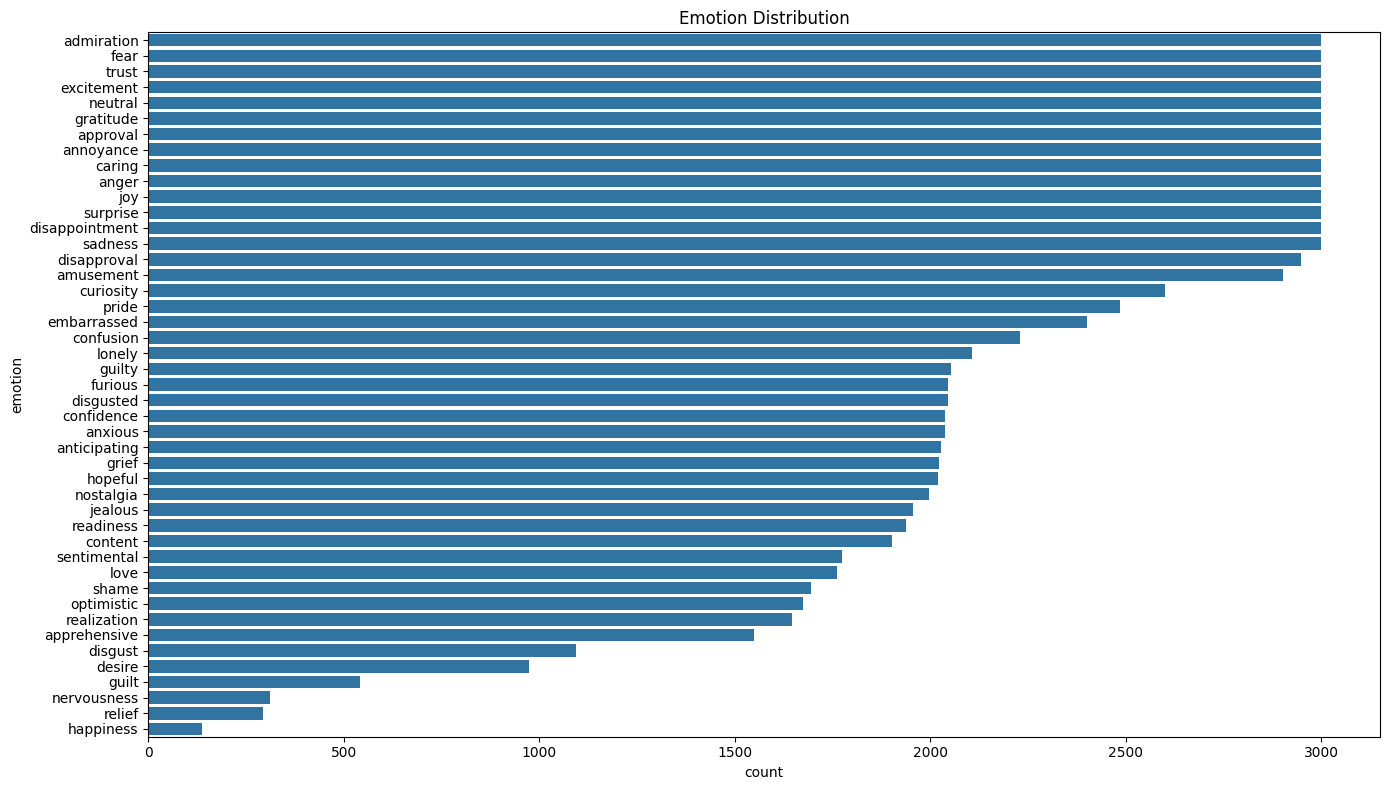

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 8))
sns.countplot(data=balanced_df, y='emotion', order=balanced_df['emotion'].value_counts().index)
plt.title("Emotion Distribution")
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import re
from textblob import TextBlob
from google.colab import files
# Step 1: Normalize text
def normalize_text(text):
    text = str(text).lower()
    text = re.sub(r"[^a-zA-Z0-9\s']", '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Step 2: Spell correction (on balanced_df only to save time)
def correct_spelling(text):
    return str(TextBlob(text).correct())

# Apply normalization
combined_df['utterance'] = combined_df['utterance'].apply(normalize_text)
balanced_df['utterance'] = balanced_df['utterance'].apply(normalize_text)

# Apply spell correction (can take time)
balanced_df['utterance'] = balanced_df['utterance'].apply(correct_spelling)

In [ ]:
# Step 4: Download files (in Colab)
files.download("combined_df_cleaned.csv")
files.download("balanced_df_cleaned.csv")

In [ ]:
# Count individual emotions
emotion_counts_full = balanced_df["emotion"].value_counts().reset_index()
emotion_counts_full.columns = ["emotion", "count"]

# Display full emotion count list
print(emotion_counts_full)